In [3]:
import numpy as np
import cv2

In [212]:
def rel2pix(x, res=224):
  return np.floor(x * res).astype(int)

def generate(res=224, thickness=2, lineType=cv2.LINE_AA, rng=None):
  if rng is None:
    rng = np.random.default_rng()

  # Create a blank transparent image (RGBA)
  image = np.full((224, 224, 3), 255, dtype=np.uint8)

  xs = rel2pix([0.01, 0.34, 0.67] + rng.uniform(size=3) * 0.32, res)

  while True:  # Avoid pathologies where the ends are very close.
    y1s = rel2pix(rng.uniform(size=3), res)
    y2s = rel2pix(rng.uniform(size=3), res)
    if np.all(np.abs(y1s - y2s) > 2 * thickness):
      break

  # Draw lines and count intersections.
  n = 0
  for i in range(len(xs) - 1):
    cv2.line(image, (xs[i], y1s[i]), [xs[i+1], y1s[i+1]], color=(255, 0, 0, 255), thickness=thickness, lineType=lineType)
    cv2.line(image, (xs[i], y2s[i]), [xs[i+1], y2s[i+1]], color=(0, 0, 255, 255), thickness=thickness, lineType=lineType)
    n += (y1s[i] - y2s[i]) * (y1s[i+1] - y2s[i+1]) < 0

  return image, n

1


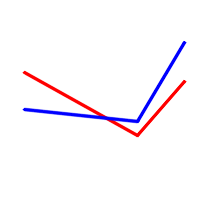

In [213]:
from PIL import Image
from IPython.display import display

# Display the image in Colab
img, n = generate()
print(n)
display(Image.fromarray(img))

In [ ]:
import json
from tqdm.notebook import tqdm
from collections import Counter

!mkdir -p lines_data

# Create balanced test-sets:
rng = np.random.default_rng(42)
with open('lines_data/val.jsonl', 'w+') as f:
  class_counts = Counter()
  while set(class_counts.values()) != {333}:
    img, c = generate(rng=rng)
    if (n := class_counts[c]) < 333:
      fname = f'val_{c}_{n:03d}.png'
      cv2.imwrite('lines_data/' + fname, img)
      f.write(json.dumps({'suffix': str(c), 'image': fname}) + "\n")
      class_counts[c] += 1
    print(f"\r{class_counts}", end="", flush=True)

# Create just large imbalanced train-set:
rng = np.random.default_rng(1337)
with open('lines_data/train.jsonl', 'w+') as f:
  for fname in (f'train_{i:05d}.png' for i in tqdm(range(10_000))):
    img, c = generate(rng=rng)
    cv2.imwrite('lines_data/' + fname, img)
    f.write(json.dumps({'suffix': str(c), 'image': fname}) + "\n")